# Module 1. Personalize User-Item Interaction Data 준비 및 환경 설정

MovieLens 데이터 세트에서 수집된 데이터를 기반으로, 영화에 대한 추천 모델을 작성하는 법을 안내합니다. 목표는 특정 사용자를 기반으로 하는 영화를 추천하는 것입니다.<br>
이 노트북에서는 전체적으로 데이타를 준비하는 단계입니다. 그러기 위해서 아래와 같은 작업을 수행 합니다. <br>

* S3 버킷 설정, 데이타 다운로드 및 S3에 데이타 업로드
* 데이타 스키마 생성
* 데이타 세트 그룹 생성 (DatasetGroup)
* 데이타 세트 생성 (Dataset)
* 환경 설정 (S3 버킷에 정책(Policy) 부여, Personalize 역할(Role) 생성)
* 데이타 Import (S3 --> Personalize 서비스로 이동)

이 노트북을 모두 실행하는데 걸리는 시간은 약 20 ~ 30 분 소요 됩니다.

## Notebook 사용법

코드는 여러 코드 셀들로 구성됩니다. 이 페이지의 상단에 삼각형으로 된 실행 단추를 마우스로 클릭하여 각 셀을 실행하고 다음 셀로 이동할 수 있습니다. 또는 셀에서 키보드 단축키 `Shift + Enter`를 눌러 셀을 실행하고 다음 셀로 이동할 수도 있습니다.

셀이 실행되면 셀이 실행되는 동안 측면에 줄이 * 표시되어 있거나 셀 내의 모든 코드를 예측한 후 실행이 완료된 마지막 셀을 나타내기 위해 숫자로 업데이트됩니다.

아래 지침을 따르고 셀을 실행하여 Amazon Personalize를 시작하세요.

## Library Import 

파이썬에는 광범위한 라이브러리 모음이 포함되어 있으며, 본 LAB을 위해서 핵심 Data Scientist용 Tool 인 boto3 (AWS SDK) 및 Pandas/Numpy와 같은 라이브러리를 가져와야 합니다. 

In [1]:
# Imports
import boto3
import json
import numpy as np
import pandas as pd
import time
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdate
from botocore.exceptions import ClientError

다음으로 여러분의 환경이 Amazon Personalize와 성공적으로 통신할 수 있는지 확인해야 합니다.

In [2]:
# Configure the SDK to Personalize:
personalize = boto3.client('personalize')
personalize_runtime = boto3.client('personalize-runtime')

생성할 오브젝트의 끝에 임의의 숫자를 부여하기 위해 suffix 정의

In [3]:
suffix = str(np.random.uniform())[4:9]

## 데이터 설정

아래에서는 Personalize LAB을 위해 AWS에서 생성한 버킷을 지정합니다.

아래에서 `bucket` 변수를 업데이트하여 CloudFormation 단계에서 앞서 생성한 값으로 설정해 주세요. 이는 이전 작업의 텍스트 파일에 있어야 합니다.(CloudFormation을 사용한 경우).<br>

### S3 버킷 및 데이터 출력 위치 지정

In [4]:
import sagemaker
#bucket='personalize-jihye-seo' # replace with the name of your S3 bucket
bucket = sagemaker.Session().default_bucket()  

### 훈련 데이터 다운로드, 준비 및 업로드

아래 코드를 실행하여 LAB을 수행할 MovieLens 데이터를 다운로드 받습니다. 

Personalize에서 학습을 수행하기 위해서는 다음과 [official limits](https://docs.aws.amazon.com/personalize/latest/dg/limits.html)같은 데이터 요구사항을 맞추어야 합니다. 

* 최소 25명 고유 사용자 
* 최소 100개 고유 아이템 
* 사용자 당 2개 이상의 Interaction(예. 구매,평가 등) 기록


하지만 일반적으로 다음과 같은 데이터가 준비 되어 있는것이 좋습니다. 

* 최소 50명 고유 사용자 
* 최소 100개 고유 아이템 
* 사용자 당 24 이상의 Interaction(예. 구매,평가 등) 기록



### 데이터 세트 다운로드 및 탐색

In [5]:
!wget -N http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip -o ml-1m.zip
df_all = pd.read_csv('./ml-1m/ratings.dat',sep='::',names=['USER_ID','ITEM_ID','EVENT_VALUE', 'TIMESTAMP'])
df_all['EVENT_TYPE']='RATING'
items_all = pd.read_csv('./ml-1m/movies.dat',sep='::', encoding='latin1',names=['ITEM_ID', '_TITLE', 'GENRE'],)
del items_all['_TITLE']
pd.set_option('display.max_rows', 5)

--2020-09-19 12:12:12--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘ml-1m.zip’ not modified on server. Omitting download.

Archive:  ml-1m.zip
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


데이터를 한번 확인해 봅니다.

In [43]:
items = items_all.copy()
items

,ITEM_ID,GENRE
0,1,Animation|Children's|Comedy
1,2,Adventure|Children's|Fantasy
...,...,...
3881,3951,Drama
3882,3952,Drama|Thriller


In [62]:
df = df_all.copy()
df

,USER_ID,ITEM_ID,EVENT_VALUE,TIMESTAMP,EVENT_TYPE
0,1,1193,5,978300760,RATING
1,1,661,3,978302109,RATING
...,...,...,...,...,...
1000207,6040,1096,4,956715648,RATING
1000208,6040,1097,4,956715569,RATING


###  데이터 준비 

이 데이터에는 UserID, ItemID, Rating 및 Timestamp 컬럼이 포함되어 있습니다.<br>

    1) Cold Start item 테스트를 위해 고유한 아이템 50% 에대한 interaction 데이터를 분리합니다. 
       * Coldstart 테스트 용으로는 더 적은 데이터만 남기셔도 됩니다. 
         이번 Lab에서는 Training 시간 단축을 위해 50%정도 데이터만 학습에 사용합니다. 
    2) 모델 완성 후 성능 검증하기 위해 남은 데이터에서 추가로 모든 사용자의 마지막 10% 데이터를 분리합니다.
![image.png](static/imgs/img_datasplit50_v1.JPG)


#### 1) Cold Start item에 따라 Interaction 분리하기 

In [63]:
# Create list of unique items
unique_items = df['ITEM_ID'].unique()
unique_items = np.random.permutation(unique_items)
len(unique_items)


3706

In [64]:
warm_items = unique_items[len(unique_items)//2:]
cold_items = unique_items[:len(unique_items)//2]
print("The number of Warm_items: {}".format(len(warm_items)))
print("The number of Cold_items: {}".format(len(cold_items)))

The number of Warm_items: 1853
The number of Cold_items: 1853


In [65]:
#Create Training data with only Warm-item
df['to_keep'] = df['ITEM_ID'].apply(lambda x:x in warm_items)
df=df[df['to_keep']]
del df['to_keep']
df

,USER_ID,ITEM_ID,EVENT_VALUE,TIMESTAMP,EVENT_TYPE
0,1,1193,5,978300760,RATING
2,1,914,3,978301968,RATING
...,...,...,...,...,...
1000205,6040,1094,5,956704887,RATING
1000206,6040,562,5,956704746,RATING


In [66]:
#Creat Cold Start interaction data with Cold-item
df_coldstart=df_all.copy()
df_coldstart['to_keep']=df_coldstart['ITEM_ID'].apply(lambda x:x in cold_items)
df_coldstart=df_coldstart[df_coldstart['to_keep']]
del df_coldstart['to_keep']
df_coldstart

,USER_ID,ITEM_ID,EVENT_VALUE,TIMESTAMP,EVENT_TYPE
1,1,661,3,978302109,RATING
4,1,2355,5,978824291,RATING
...,...,...,...,...,...
1000207,6040,1096,4,956715648,RATING
1000208,6040,1097,4,956715569,RATING


In [67]:
len(df['ITEM_ID'].unique())

1853

In [68]:
#Create metadata with only items in the interaction
items['to_keep'] = items['ITEM_ID'].apply(lambda x:x in unique_items)
items=items[items['to_keep']]
del items['to_keep']
items

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,ITEM_ID,GENRE
0,1,Animation|Children's|Comedy
1,2,Adventure|Children's|Fantasy
...,...,...
3881,3951,Drama
3882,3952,Drama|Thriller


In [69]:
print('Training Dataset: unique users %d; unique items %d'%(
    len(df['USER_ID'].unique()), len(df['ITEM_ID'].unique())))

Training Dataset: unique users 6040; unique items 1853


In [70]:
print('Cold_Start Dataset: unique users %d; unique items %d'%(
    len(df_coldstart['USER_ID'].unique()), len(df_coldstart['ITEM_ID'].unique())))

Cold_Start Dataset: unique users 6040; unique items 1853


#### 2) 검증용 데이터 분리하기 

모든 사용자의 마지막(Timestamp기준으로) 10%의 데이터를 Hold-out test데이터로 분리합니다.

In [71]:
ranks = df.groupby('USER_ID').TIMESTAMP.rank(pct=True, method='first')
df = df.join((ranks>0.9).to_frame('holdout'))
holdout = df[df['holdout']].drop('holdout', axis=1)
df = df[~df['holdout']].drop('holdout', axis=1)

In [72]:
print('Training Dataset: unique users %d; unique items %d'%(
    len(df['USER_ID'].unique()), len(df['ITEM_ID'].unique())))
df

Training Dataset: unique users 6040; unique items 1845


,USER_ID,ITEM_ID,EVENT_VALUE,TIMESTAMP,EVENT_TYPE
0,1,1193,5,978300760,RATING
2,1,914,3,978301968,RATING
...,...,...,...,...,...
1000205,6040,1094,5,956704887,RATING
1000206,6040,562,5,956704746,RATING


In [73]:
print('Validataion Dataset: unique users %d; unique items %d'%(
    len(holdout['USER_ID'].unique()), len(holdout['ITEM_ID'].unique())))
holdout

Validataion Dataset: unique users 6040; unique items 1724


,USER_ID,ITEM_ID,EVENT_VALUE,TIMESTAMP,EVENT_TYPE
30,1,2294,4,978824291,RATING
34,1,1907,4,978824330,RATING
...,...,...,...,...,...
1000172,6040,1784,3,997454464,RATING
1000178,6040,3703,4,964828575,RATING


In [74]:
user_activity_counts = df.groupby("USER_ID").count().loc[:,["EVENT_TYPE"]].rename(columns={"EVENT_TYPE":"INTERACTION_COUNTS"})
print(user_activity_counts.info())
user_activity_counts.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6040 entries, 1 to 6040
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   INTERACTION_COUNTS  6040 non-null   int64
dtypes: int64(1)
memory usage: 94.4 KB
None


,INTERACTION_COUNTS
USER_ID,
1,22
2,61
3,22
4,8
5,86


In [75]:
test=user_activity_counts.quantile([.1,.2,.3,.4,.5,.6,.8,.9,.95,.99,.999,.9999,1.0])
test

,INTERACTION_COUNTS
0.1000,11.000
0.2000,16.000
...,...
0.9999,918.142
1.0000,1051.000


In [76]:
test.to_csv('interaction_counts.csv')

In [77]:
user_activity_counts=user_activity_counts.reset_index()
activities = user_activity_counts.groupby('INTERACTION_COUNTS').count()
activities.columns=['NUM_USERS']
activities

,NUM_USERS
INTERACTION_COUNTS,
4,4
5,16
...,...
831,1
1051,1


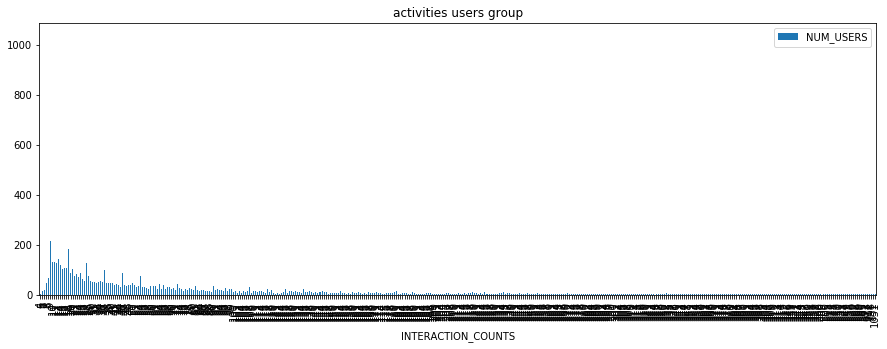

In [78]:
activities.loc[:,:].plot(kind='bar', figsize=(15,5), ylim=(0,1089))
plt.title("activities users group")

plt.show()

### S3로 데이터 업로드 하기

완료되면 파일을 새 CSV로 저장한 다음, S3에 업로드합니다.<br>

In [23]:
#!mkdir dataset
interaction_filename="dataset/training_interaction.csv"
items_filename="dataset/training_item.csv"
df.to_csv(interaction_filename,index=False)
items.to_csv(items_filename,index=False)

#These files will be used for later for evaluation step 
coldstart_interation_filename="dataset/coldstart_interaction.csv"
validation_interaction_filename="dataset/validation_interaction.csv"
df_coldstart.to_csv(coldstart_interation_filename,index=False)
holdout.to_csv(validation_interaction_filename,index=False)      


In [24]:
#upload file for training
boto3.Session().resource('s3').Bucket(bucket).Object(interaction_filename).upload_file(interaction_filename)
boto3.Session().resource('s3').Bucket(bucket).Object(items_filename).upload_file(items_filename)

#boto3.Session().resource('s3').Bucket(bucket).Object(coldstart_interation_filename).upload_file(coldstart_interation_filename)
#boto3.Session().resource('s3').Bucket(bucket).Object(validation_interaction_filename).upload_file(validation_interaction_filename)


## 스키마 생성

Personalize가 데이터를 이해하는 방법의 핵심 구성 요소는 아래 정의 된 스키마(schema)에서 비롯됩니다. 이 설정은 CSV 파일을 통해 제공된 데이터를 요약하는 방법을 Personalize 서비스에 알려줍니다. 열(column)과 유형(type)은 위에서 만든 파일의 내용과 일치합니다.

In [25]:
interaction_schema_name="DEMO-interaction-schema-"+suffix

In [26]:
schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "EVENT_VALUE",
            "type": "float"
        },
        {
            "name": "TIMESTAMP",
            "type": "long"
        },
        { 
            "name": "EVENT_TYPE",
            "type": "string"
        },
    ],
    "version": "1.0"
}


create_schema_response = personalize.create_schema(
    name = interaction_schema_name,
    schema = json.dumps(schema)
)

interaction_schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:ap-northeast-2:870180618679:schema/DEMO-interaction-schema-36654",
  "ResponseMetadata": {
    "RequestId": "b7ec4e7f-a7b0-4918-9ee7-4c58a1f61a62",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 19 Sep 2020 12:12:29 GMT",
      "x-amzn-requestid": "b7ec4e7f-a7b0-4918-9ee7-4c58a1f61a62",
      "content-length": "100",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [27]:
item_schema_name="DEMO-item-schema-"+suffix

In [28]:
item_schema = {
    "type": "record",
    "name": "Items",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
    {
        "name": "ITEM_ID",
        "type": "string"
    },
    {
        "name": "GENRE",
        "type": "string",
        "categorical": True
    }
    ],
    "version": "1.0"
}

create_metadata_schema_response = personalize.create_schema(
    name = item_schema_name,
    schema = json.dumps(item_schema)
)

item_schema_arn = create_metadata_schema_response['schemaArn']
print(json.dumps(create_metadata_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:ap-northeast-2:870180618679:schema/DEMO-item-schema-36654",
  "ResponseMetadata": {
    "RequestId": "1837d8b7-d365-424c-993d-264fa7175fec",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 19 Sep 2020 12:12:29 GMT",
      "x-amzn-requestid": "1837d8b7-d365-424c-993d-264fa7175fec",
      "content-length": "93",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


## 데이터 세트 그룹 생성 및 대기

Personalize에서 가장 큰 단위는 **데이터 세트 그룹(Dataset Group)** 이며, 이렇게 하면 데이터, 이벤트 추적기(event tracker), 솔루션(solution) 및 캠페인(campaign)이 분리됩니다. 공통의 데이터 수집을 공유하는 것들을 그룹화합니다. 원하는 경우 아래 그룹명을 자유롭게 변경해 주세요.

### 데이터 세트 그룹 생성

In [29]:
create_dataset_group_response = personalize.create_dataset_group(
    name = "DEMO-dataset-group-" + suffix
)

dataset_group_arn = create_dataset_group_response['datasetGroupArn']
print(json.dumps(create_dataset_group_response, indent=2))

{
  "datasetGroupArn": "arn:aws:personalize:ap-northeast-2:870180618679:dataset-group/DEMO-dataset-group-36654",
  "ResponseMetadata": {
    "RequestId": "04eca093-69b6-40db-acfb-18693eaca143",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 19 Sep 2020 12:12:29 GMT",
      "x-amzn-requestid": "04eca093-69b6-40db-acfb-18693eaca143",
      "content-length": "108",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### 데이터 세트 그룹이 활성화 상태가 될 때까지 대기

아래의 모든 항목에서 Dataset Group을 사용하려면 활성화(active)가 되어야 합니다. 아래 셀을 실행하고 DatasetGroup: ACTIVE로 변경될 때까지 기다려 주세요.

In [30]:
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_group_response = personalize.describe_dataset_group(
        datasetGroupArn = dataset_group_arn
    )
    status = describe_dataset_group_response["datasetGroup"]["status"]
    print("DatasetGroup: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(15)

DatasetGroup: CREATE PENDING
DatasetGroup: CREATE PENDING
DatasetGroup: ACTIVE


### 데이터 세트 생성

그룹 다음으로 생성할 것은 실제 데이터 세트입니다. 아래의 코드 셀을 실행하여 데이터 세트을 생성해 주세요.

### Interaction 데이터 세트 생성

In [31]:
dataset_type = "INTERACTIONS"
create_dataset_response = personalize.create_dataset(
    name = "DEMO-interaction-dataset-" + suffix,
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = interaction_schema_arn
)

interaction_dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:ap-northeast-2:870180618679:dataset/DEMO-dataset-group-36654/INTERACTIONS",
  "ResponseMetadata": {
    "RequestId": "e90e1257-ef32-4b76-b0ba-ca9afb403bb3",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 19 Sep 2020 12:12:59 GMT",
      "x-amzn-requestid": "e90e1257-ef32-4b76-b0ba-ca9afb403bb3",
      "content-length": "110",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


###  ITEM 데이터 세트 생성 

In [32]:
dataset_type = "ITEMS"
create_item_dataset_response = personalize.create_dataset(
    name = "DEMO-item-dataset-" + suffix,
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = item_schema_arn,
  
)

item_dataset_arn = create_item_dataset_response['datasetArn']
print(json.dumps(create_item_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:ap-northeast-2:870180618679:dataset/DEMO-dataset-group-36654/ITEMS",
  "ResponseMetadata": {
    "RequestId": "46d2ce45-e96c-4053-b6dd-c04dd60d7f89",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 19 Sep 2020 12:13:00 GMT",
      "x-amzn-requestid": "46d2ce45-e96c-4053-b6dd-c04dd60d7f89",
      "content-length": "103",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### S3 버킷에 정책 부여

Amazon Personalize는 앞서 생성한 S3 버킷의 내용을 읽을 수 있어야 합니다. 아래 코드 셀로 S3 버킷 접근 정책(policy)을 부여합니다.

In [33]:
s3 = boto3.client("s3")

policy = {
    "Version": "2012-10-17",
    "Id": "PersonalizeS3BucketAccessPolicy",
    "Statement": [
        {
            "Sid": "PersonalizeS3BucketAccessPolicy",
            "Effect": "Allow",
            "Principal": {
                "Service": "personalize.amazonaws.com"
            },
            "Action": [
                "s3:*Object",
                "s3:ListBucket",
            ],
            "Resource": [
                "arn:aws:s3:::{}".format(bucket),
                "arn:aws:s3:::{}/*".format(bucket)
            ]
        }
    ]
}

s3.put_bucket_policy(Bucket=bucket, Policy=json.dumps(policy))

{'ResponseMetadata': {'RequestId': '9B32376B90CEEF6D',
  'HostId': 'g48pyGz0mP6TUuLH59p3wYlCPsnWk8F4xoc/3thljItHypaTDah4oQh3/FR/Q57ozv9HR+P2kd4=',
  'HTTPStatusCode': 204,
  'HTTPHeaders': {'x-amz-id-2': 'g48pyGz0mP6TUuLH59p3wYlCPsnWk8F4xoc/3thljItHypaTDah4oQh3/FR/Q57ozv9HR+P2kd4=',
   'x-amz-request-id': '9B32376B90CEEF6D',
   'date': 'Sat, 19 Sep 2020 12:13:01 GMT',
   'server': 'AmazonS3'},
  'RetryAttempts': 0}}

### Personalize IAM Role 생성

또한, Amazon Personalize는 특정 작업들을 실행할 권한을 갖기 위해, AWS에서 역할을 맡을 수 있는 기능이 필요합니다. 

In [34]:
iam = boto3.client("iam")

role_name = "PersonalizeRoleDemo" + suffix
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "personalize.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}

create_role_response = iam.create_role(
    RoleName = role_name,
    AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
)

# AmazonPersonalizeFullAccess provides access to any S3 bucket with a name that includes "personalize" or "Personalize" 
# if you would like to use a bucket with a different name, please consider creating and attaching a new policy
# that provides read access to your bucket or attaching the AmazonS3ReadOnlyAccess policy to the role
policy_arn = "arn:aws:iam::aws:policy/service-role/AmazonPersonalizeFullAccess"
iam.attach_role_policy(
    RoleName = role_name,
    PolicyArn = policy_arn
)

# Now add S3 support
iam.attach_role_policy(
    RoleName=role_name,    
    PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess'
)
time.sleep(60) # wait for a minute to allow IAM role policy attachment to propagate

role_arn = create_role_response["Role"]["Arn"]
print(role_arn)

arn:aws:iam::870180618679:role/PersonalizeRoleDemo36654


### 데이터 세트 Import

이전에는 정보를 저장하기 위해 데이터 세트 그룹 및 데이터 세트를 생성했으므로, 
이제는 모델 구축을 위해 S3에서 Amazon Personalize로 데이터를 로드하는 import job을 실행합니다.

#### Interaction 데이터 세트 Import Job 생성

In [35]:
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "demo-interaction-dataset-import-" + suffix,
    datasetArn = interaction_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket, interaction_filename)
    },
    roleArn = role_arn
)

interation_dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:ap-northeast-2:870180618679:dataset-import-job/demo-interaction-dataset-import-36654",
  "ResponseMetadata": {
    "RequestId": "a5136390-c29f-4808-b04f-909275d13cae",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 19 Sep 2020 12:14:01 GMT",
      "x-amzn-requestid": "a5136390-c29f-4808-b04f-909275d13cae",
      "content-length": "130",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### 아이템 데이터 세트 Import Job 생성

In [36]:
create_item_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "demo-item-dataset-import-" + suffix,
    datasetArn = item_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket, items_filename)
    },
    roleArn = role_arn
)

item_dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_dataset_import_job_response, indent=2))


{
  "datasetImportJobArn": "arn:aws:personalize:ap-northeast-2:870180618679:dataset-import-job/demo-interaction-dataset-import-36654",
  "ResponseMetadata": {
    "RequestId": "a5136390-c29f-4808-b04f-909275d13cae",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 19 Sep 2020 12:14:01 GMT",
      "x-amzn-requestid": "a5136390-c29f-4808-b04f-909275d13cae",
      "content-length": "130",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### 데이터 세트 Import job이 활성화 상태가 될 때까지 대기

Import job이 완료되기까지 시간이 걸립니다. 아래 코드 셀의 출력 결과가 DatasetImportJob: ACTIVE가 될 때까지 기다려 주세요.

In [37]:
%%time

status = None
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_import_job_response = personalize.describe_dataset_import_job(
        datasetImportJobArn = interation_dataset_import_job_arn
    )
    
    dataset_import_job = describe_dataset_import_job_response["datasetImportJob"]
    if "latestDatasetImportJobRun" not in dataset_import_job:
        status = dataset_import_job["status"]
        print("DatasetImportJob: {}".format(status))
    else:
        status = dataset_import_job["latestDatasetImportJobRun"]["status"]
        print("LatestDatasetImportJobRun: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)

DatasetImportJob: CREATE PENDING
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: ACTIVE
CPU times: user 83.3 ms, sys: 455 µs, total: 83.8 ms
Wall time: 12min


In [38]:
status = None
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_import_job_response = personalize.describe_dataset_import_job(
        datasetImportJobArn = item_dataset_import_job_arn
    )
    
    dataset_import_job = describe_dataset_import_job_response["datasetImportJob"]
    if "latestDatasetImportJobRun" not in dataset_import_job:
        status = dataset_import_job["status"]
        print("DatasetImportJob: {}".format(status))
    else:
        status = dataset_import_job["latestDatasetImportJobRun"]["status"]
        print("LatestDatasetImportJobRun: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)



DatasetImportJob: ACTIVE


## Review

위의 코드를 사용하여 데이타 세트 그룹, 데이타 세트, 데이타 세트 Import까지를 수행 하였습니다. 다음 단계는 이를 기반으로 솔류션(모델)을 생성하는 단계를 진행 합니다..

이제 다음 노트북으로 넘어갈 준비가 되었습니다. (`2.Creating_and_Evaluating_Solutions.ipynb`)


## 다음 노트북에 대한 참고 사항

다음 실습에 필요한 몇 가지 값들이 있습니다. 아래 셀을 실행하여 저장한 후, 다음 주피터 노트북에서 그대로 사용할 수 있습니다.

In [39]:
%store dataset_group_arn
%store interaction_dataset_arn
%store item_dataset_arn
%store interaction_schema_arn
%store item_schema_arn
%store bucket
%store interaction_filename
%store items_filename
%store validation_interaction_filename
%store coldstart_interation_filename
%store role_name
%store role_arn
%store cold_items
%store warm_items
%store unique_items

Stored 'dataset_group_arn' (str)
Stored 'interaction_dataset_arn' (str)
Stored 'item_dataset_arn' (str)
Stored 'interaction_schema_arn' (str)
Stored 'item_schema_arn' (str)
Stored 'bucket' (str)
Stored 'interaction_filename' (str)
Stored 'items_filename' (str)
Stored 'validation_interaction_filename' (str)
Stored 'coldstart_interation_filename' (str)
Stored 'role_name' (str)
Stored 'role_arn' (str)
Stored 'cold_items' (ndarray)
Stored 'warm_items' (ndarray)
Stored 'unique_items' (ndarray)
